# LSTM ARCHITECTURE


Found 1604 images belonging to 20 classes.
Found 396 images belonging to 20 classes.
Found 2505 images belonging to 20 classes.


1/1 [==============================] - 0s 134ms/step
Epoch 1/10


51/51 [==============================] - 9s 105ms/step - loss: 1.9030 - accuracy: 0.4956 - val_loss: 1.0742 - val_accuracy: 0.7172
Epoch 2/10
51/51 [==============================] - 4s 84ms/step - loss: 0.7570 - accuracy: 0.7974 - val_loss: 0.7158 - val_accuracy: 0.7677
Epoch 3/10
51/51 [==============================] - 4s 84ms/step - loss: 0.5005 - accuracy: 0.8560 - val_loss: 0.7613 - val_accuracy: 0.7525
Epoch 4/10
51/51 [==============================] - 5s 90ms/step - loss: 0.4010 - accuracy: 0.8853 - val_loss: 0.5523 - val_accuracy: 0.8157
Epoch 5/10
51/51 [==============================] - 5s 90ms/step - loss: 0.2681 - accuracy: 0.9239 - val_loss: 0.5439 - val_accuracy: 0.8106
Epoch 6/10
51/51 [==============================] - 5s 93ms/step - loss: 0.2210 - accuracy: 0.9364 - val_los

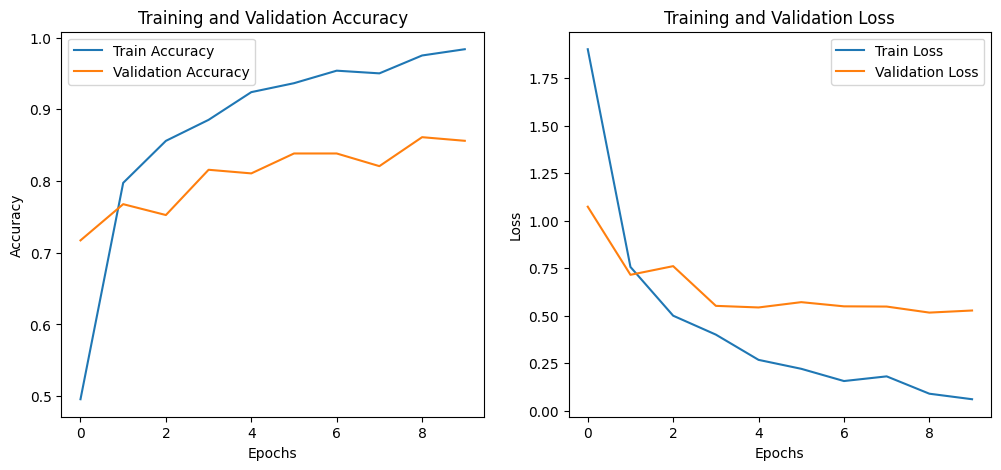

79/79 [==============================] - 3s 29ms/step


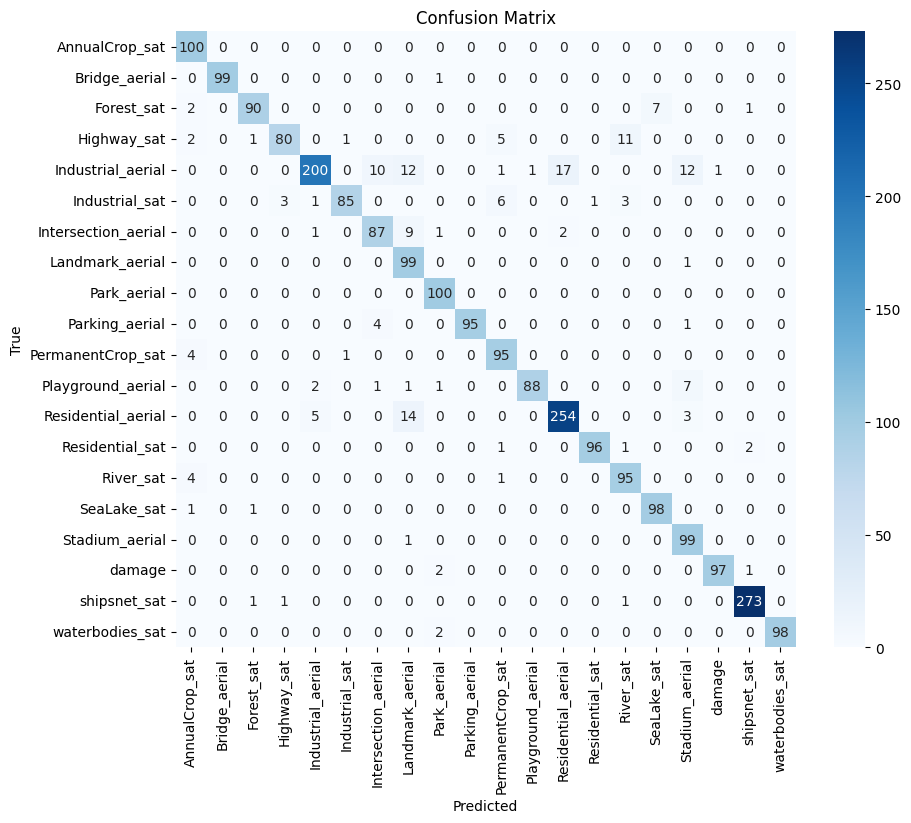

Classification Report:
                     precision    recall  f1-score   support

     AnnualCrop_sat       0.88      1.00      0.94       100
      Bridge_aerial       1.00      0.99      0.99       100
         Forest_sat       0.97      0.90      0.93       100
        Highway_sat       0.95      0.80      0.87       100
  Industrial_aerial       0.96      0.79      0.86       254
     Industrial_sat       0.98      0.86      0.91        99
Intersection_aerial       0.85      0.87      0.86       100
    Landmark_aerial       0.73      0.99      0.84       100
        Park_aerial       0.93      1.00      0.97       100
     Parking_aerial       1.00      0.95      0.97       100
  PermanentCrop_sat       0.87      0.95      0.91       100
  Playground_aerial       0.99      0.88      0.93       100
 Residential_aerial       0.93      0.92      0.93       276
    Residential_sat       0.99      0.96      0.97       100
          River_sat       0.86      0.95      0.90       100


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Set dataset paths
dataset_path = "DATASET"
train_path = os.path.join(dataset_path, "TRAIN")
test_path = os.path.join(dataset_path, "TEST")

# Image settings
img_size = (224, 224)  # Input size for MobileNetV2
batch_size = 32

# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='training')

val_generator = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = len(train_generator.class_indices)

# CNN for feature extraction
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Function to extract features
def extract_features(generator):
    features, labels = [], []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x_features = base_model.predict(x_batch)
        x_features = x_features.reshape(x_features.shape[0], -1, x_features.shape[-1])
        features.append(x_features)
        labels.append(y_batch)
        if len(features) * batch_size >= generator.samples:
            break
    return np.vstack(features), np.vstack(labels)

# Extract features for train, validation, and test data
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(val_generator)
X_test, y_test = extract_features(test_generator)

# Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Predict and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=train_generator.class_indices.keys()))
